In [1]:
from cmeutils import gsd_utils
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import freud

In [2]:
def get_molecule_cluster(gsd_file=None, snap=None, gsd_frame=-1):
    """Find molecule index for each particle.

    Compute clusters of bonded molecules and return an array of the molecule
    index of each particle.
    Pass in either a gsd file or a snapshot, but not both

    Parameters
    ----------
    gsd_file : str, default None
        Filename of the gsd trajectory
    snap : gsd.hoomd.Frame, default None
        Trajectory snapshot.
    gsd_frame : int, default -1
        Frame number of gsd_file to use to compute clusters.

    Returns
    -------
    numpy.ndarray (N_particles,)
    """
    #snap = _validate_inputs(gsd_file, snap, gsd_frame)
    system = freud.AABBQuery.from_system(snap)
    n_query_points = n_points = snap.particles.N
    query_point_indices = snap.bonds.group[:, 0]
    point_indices = snap.bonds.group[:, 1]
    box = freud.box.Box(
        snap.configuration.box[0],
        snap.configuration.box[1],
        snap.configuration.box[2],
    )
    vectors = box.wrap(
        snap.particles.position[query_point_indices]
        - snap.particles.position[point_indices]
    )
    nlist = freud.NeighborList.from_arrays(
        num_query_points=n_query_points,
        num_points=n_points,
        query_point_indices=query_point_indices,
        point_indices=point_indices,
        vectors=vectors,
    )
    cluster = freud.cluster.Cluster()
    cluster.compute(system=system, neighbors=nlist)
    cl_props = freud.cluster.ClusterProperties()
    cl_props.compute(system, cluster.cluster_idx)
    return cluster, cl_props

In [42]:
def radius_of_gyration(gsd_file, start=0, stop=-1, stride=1):
    """Calculates the radius of gyration using Freud's cluster module.
    Code written by Chris Jones, chrisjonesBSU

    Parameters
    ----------
    gsd_file : str; required
        Path to a gsd_file
    start: int; optional; default 0
        The frame index of the trajectory to begin with
    stop: int; optional; default -1
        The frame index of the trajectory to end with

    Returns
    -------
    rg_array : List of arrays of floats
        Array of individual chain Rg values for each frame
    rg_means : List of floats
        Average Rg values for each frame
    rg_std : List of floats
        Standard deviations of Rg values for each frame
    """
    trajectory = gsd.hoomd.open(gsd_file, mode="r")
    rg_values = []
    rg_means = []
    rg_std = []
    for snap in trajectory[start:stop:stride]:
        clusters, cl_props = get_molecule_cluster(snap=snap)
        rg_values.append(cl_props.radii_of_gyration)
        rg_means.append(np.mean(cl_props.radii_of_gyration))
        rg_std.append(np.std(cl_props.radii_of_gyration))
    return rg_means, rg_std, rg_values

In [55]:
gsd_path=('cg-pps-trajectory0.gsd')
rg_means, rg_std, rg_values= radius_of_gyration(gsd_path,start=100)

Text(0, 0.5, '<R_g>')

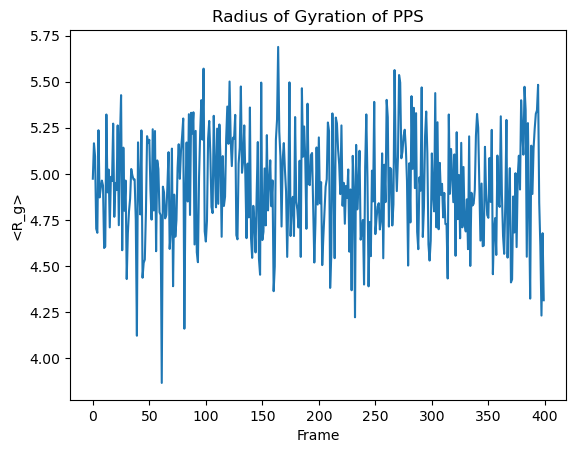

In [56]:
#plt.plot(rg_means)
plt.plot(rg_means)
plt.title("Radius of Gyration of PPS")
plt.xlabel('Frame')
plt.ylabel('<R_g>')
#plt.legend()

In [57]:
print('<R_g> over all frames: ',np.mean(rg_means))

<R_g> over all frames:  4.9315386
